<a href="https://colab.research.google.com/github/klobell/constitutions/blob/main/similarity_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Constitution Clustering and Cosine Similarities

In [ ]:
# tfidf matrices

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

vec = TfidfVectorizer(token_pattern=r'\b[a-zA-Z]+\b', max_features=100)
vec.fit(constitutions_df["Constitution"])
tfidf_matrix = vec.transform(constitutions_df["Constitution"])

words = vec.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns=words).head()
tfidf_df.head()



,a,accordance,act,after,all,an,and,any,appointed,are,...,the,their,this,time,to,under,which,who,with,within
0,0.097612,0.025664,0.001410,0.011969,0.021012,0.015426,0.184319,0.010905,0.009958,0.044683,...,0.784086,0.027661,0.027395,0.006961,0.130326,0.009701,0.017554,0.016224,0.074206,0.017022
1,0.070684,0.006358,0.002319,0.009473,0.022225,0.024047,0.219338,0.017489,0.003410,0.008744,...,0.776063,0.026962,0.022954,0.003301,0.141003,0.005906,0.010202,0.004008,0.028419,0.017853
2,0.067962,0.004867,0.000718,0.003387,0.012870,0.009935,0.352455,0.025966,0.004696,0.014902,...,0.722522,0.037707,0.012418,0.005227,0.157374,0.040033,0.025966,0.006322,0.035223,0.010612
3,0.083416,0.005175,0.003403,0.009167,0.019708,0.021542,0.248874,0.021083,0.003337,0.020625,...,0.734247,0.042625,0.045833,0.012917,0.180583,0.008359,0.028875,0.008708,0.047666,0.009167
4,0.124036,0.005114,0.006119,0.006818,0.002885,0.013636,0.180678,0.006556,0.004909,0.006294,...,0.725596,0.009440,0.006556,0.004487,0.128231,0.002923,0.008654,0.005769,0.033828,0.010227


In [ ]:
# finding closest constitutions using tfidf and cosine similarity

import pandas as pd
from sklearn.metrics import pairwise_distances

dists = pairwise_distances(tfidf_matrix, metric="cosine")

countries = constitutions_df['Country'].values

closest = []
for i in range(len(constitutions_df)):
    closest_countries = {
        countries[dists[i].argsort()[1]],
        countries[dists[i].argsort()[2]],
        countries[dists[i].argsort()[3]]
    }
    closest.append(closest_countries)

df_closest = pd.DataFrame(closest)

df_closest.columns = ["1st Closest", "2nd Closest", "3rd Closest"]

df_closest.insert(0, "Country", countries)

df_closest.head()


,Country,1st Closest,2nd Closest,3rd Closest
0,Albania,Tunisia,Guatemala,Romania
1,Algeria,Cameroon,Benin,Mali
2,Angola,Nicaragua,Bolivia,Mozambique
3,Argentina,Honduras,Dominican Republic,Colombia
4,Armenia,Benin,Poland,Serbia


## Clustering on tfidf and Making a Choropleth

In [ ]:
# clustering constitutions based on tfidf matrix

from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer


transformer = make_column_transformer(
    (TfidfVectorizer(max_features=100), "Constitution"),
    remainder="passthrough"
)

X_train = constitutions_df[["Constitution"]]

model = KMeans(n_clusters=5)

pipeline = make_pipeline(
    transformer,
    model
)

pipeline.fit(X_train)

centroids = model.cluster_centers_
clusters = model.labels_

clusters_df = pd.DataFrame({"Country": constitutions_df["Country"], "Cluster": clusters})

clusters_df.head()


,Country,Cluster
0,Albania,1
1,Algeria,3
2,Angola,4
3,Argentina,4
4,Armenia,3


Again, shapefile of the countries of the world is from [this website](https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/?flg=en-us).

In [ ]:
# merge the clusters with a gdf for choropleth plot

cluster_gdf = gpd.read_file("/content/world-administrative-boundaries.zip")
cluster_gdf.rename(columns={'name': 'Country'}, inplace=True)

# updating names to merge with clusters_df
cluster_gdf["Country"] = cluster_gdf["Country"].replace({
    "Russian Federation": "Russia",
    "Iran (Islamic Republic of)": "Iran",
    "Democratic People's Republic of Korea": "North Korea",
    "Libyan Arab Jamahiriya": "Libya",
    "Syrian Arab Republic": "Syria",
})

cluster_gdf = cluster_gdf.merge(clusters_df, on="Country", how="inner")
cluster_gdf.head()


,iso3,status,color_code,Country,continent,region,iso_3166_1_,french_shor,geometry,Cluster
0,FRA,Member State,FRA,France,Europe,Western Europe,FR,France,"MULTIPOLYGON (((9.4475 42.68305, 9.45014 42.63...",3
1,SRB,Member State,SRB,Serbia,Europe,Southern Europe,RS,Serbie,"POLYGON ((20.26102 46.11485, 20.31403 46.06986...",3
2,URY,Member State,URY,Uruguay,Americas,South America,UY,Uruguay,"POLYGON ((-53.3743 -33.74067, -53.39917 -33.75...",3
3,PAN,Member State,PAN,Panama,Americas,Central America,PA,Panama,"MULTIPOLYGON (((-81.67847 7.38861, -81.64944 7...",4
4,DZA,Member State,DZA,Algeria,Africa,Northern Africa,DZ,Algérie,"POLYGON ((8.62203 36.94137, 8.63222 36.88194, ...",3


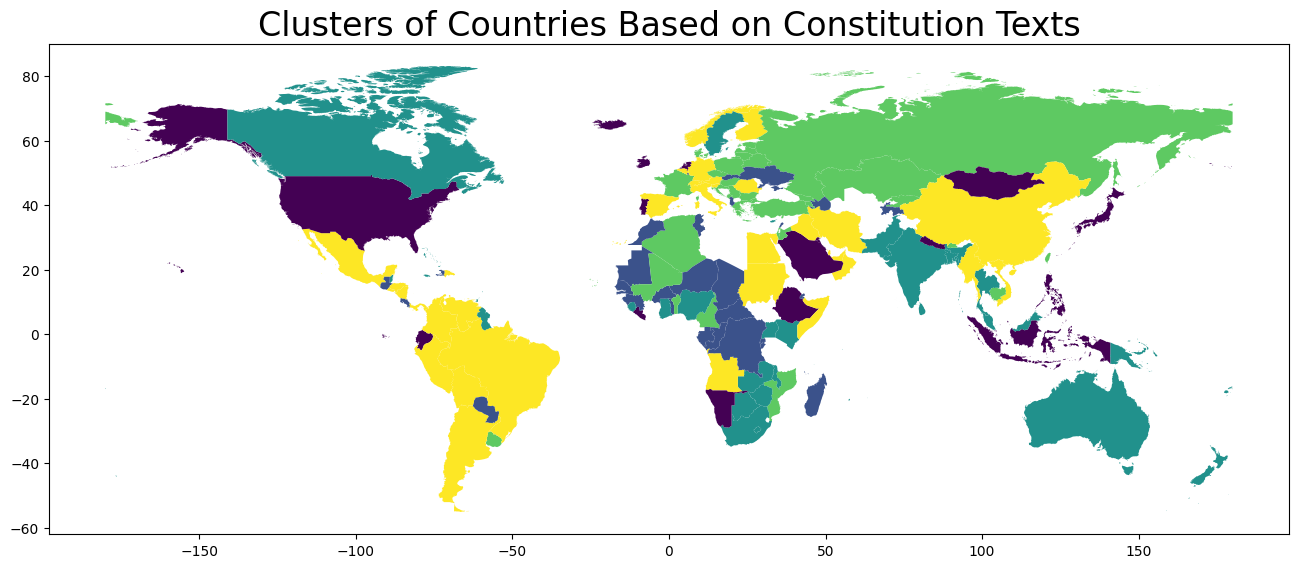

In [ ]:
# making choropleth plot

fig, ax = plt.subplots(figsize=(16, 8))
cluster_gdf.plot(column="Cluster", ax=ax)

plt.title("Clusters of Countries Based on Constitution Texts", fontsize = 24)
plt.show()

## Specific Freedom Words Counts for Each Country

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler


targets = ["liberty", "freedom", "rights", "right", "privileges", "free"]
vec = CountVectorizer(vocabulary=targets)

X_train = vec.fit_transform(constitutions_df["Constitution"])

df_counts = pd.DataFrame(X_train.toarray(), columns=vec.get_feature_names_out())
df_counts["freedom_counts"] = df_counts.sum(axis=1)
df_counts["Country"] = constitutions_df["Country"]

scaler = StandardScaler()
df_counts["freedom_counts"] = scaler.fit_transform(df_counts[["freedom_counts"]])

df_counts.head()


,liberty,freedom,rights,right,privileges,free,freedom_counts,Country
0,8,17,60,104,0,9,0.218687,Albania
1,1,26,51,61,0,9,-0.186091,Algeria
2,4,45,112,144,0,23,1.271109,Angola
3,2,2,39,18,4,12,-0.760876,Argentina
4,27,38,101,171,0,13,1.449211,Armenia
